In [1]:
%load_ext autoreload
%autoreload 2

# Janus decoder reconstruction

/home/jjc/miniconda3/envs/dllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/home/jjc/miniconda3/envs/dllm/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:604: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


[2025-05-26 06:54:11,309] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/jjc/miniconda3/envs/dllm/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/jjc/miniconda3/envs/dllm/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why t

after bottleneck x.shape: torch.Size([1, 576, 32])


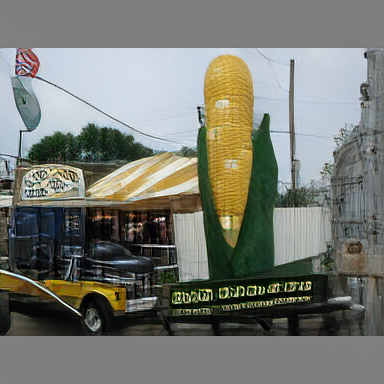

In [2]:
import os
import torch
import torchvision.transforms as pth_transforms
from PIL import Image
from omegaconf import OmegaConf
from model.decoder import get_decoder
from janus.models import MultiModalityCausalLM, VLChatProcessor


model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"

janus = MultiModalityCausalLM.from_pretrained(model_path, trust_remote_code=True)
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)

exp_path = "/data1/jjc/experiment/bi_tok/0526_janus_decoder_32"
config = OmegaConf.load(os.path.join(exp_path, "config.yaml"))
decoder = get_decoder(config.decoder)
ckpt = torch.load(os.path.join(exp_path, "Decoder-bi_tok-2k"), map_location="cpu")
decoder.load_state_dict(ckpt, strict=True)

decoder.eval()

img = Image.open("/data1/LargeData/ImageNet/val/n13133613/ILSVRC2012_val_00010376.JPEG")
pixel_values = vl_chat_processor.image_processor([img], return_tensors="pt").pixel_values
rec = decoder(janus.vision_model(pixel_values))
inversed_transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
])

rec = ((rec + 1) / 2).clamp(0, 1)
rec = inversed_transform(rec.squeeze(0))

rec

In [19]:
import torch
from omegaconf import OmegaConf
from janus.models import MultiModalityCausalLM, VLChatProcessor
from diffusers import DDIMScheduler
from torchvision import transforms as pth_transforms
from tqdm.auto import tqdm, trange
from janus.models.diff_mlp import SimpleMLPAdaLN
from model.decoder import get_decoder

model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"

janus = MultiModalityCausalLM.from_pretrained(model_path, trust_remote_code=True)
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

# janus_ckpt = torch.load("/data1/jjc/experiment/bi_tok/0526_janus_gen_32_trainlm/janus-bi_tok-15k", map_location="cpu")
# janus.language_model.load_state_dict(janus_ckpt, strict=True)

config = OmegaConf.load("config/janus_gen.yaml")
decoder = get_decoder(config.decoder)
ckpt = torch.load(config.decoder.ckpt, map_location="cpu")
decoder.load_state_dict(ckpt, strict=True)
to_bottleneck = decoder.to_bottleneck
for param in to_bottleneck.parameters():
    param.requires_grad = False
to_bottleneck.eval()

diff_head = SimpleMLPAdaLN(
    in_channels = 1024,
    model_channels = 1024,
    out_channels = 1024,
    z_channels = 2048,
    num_res_blocks = 2,
)
head_ckpt = torch.load("/data1/jjc/experiment/bi_tok/0526_janus_gen_1024/diff_head-bi_tok-5k", map_location="cpu")
diff_head.load_state_dict(head_ckpt, strict=True)

device = "cuda:5"

diff_head = diff_head.to(device).eval()
janus = janus.to(device).eval()
to_bottleneck = to_bottleneck.to(device).eval()

sample_scheduler = DDIMScheduler(
    beta_schedule          = "scaled_linear",
    beta_start             = 0.00085,
    beta_end               = 0.012,
    num_train_timesteps    = 1000,
    clip_sample            = False,
    prediction_type        = "v_prediction",
    set_alpha_to_one       = True,
    steps_offset           = 1,
    trained_betas          = None,
    timestep_spacing       = "trailing",
    rescale_betas_zero_snr = True
)
inversed_transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
])

def diff_generate(feature, diff_head):
    sample_scheduler.set_timesteps(100)
    B = feature.shape[0]

    pred_latents = torch.randn((B, 1024), device=feature.device)
    pred_latents *= sample_scheduler.init_noise_sigma

    for t in sample_scheduler.timesteps:
        pred_latents = sample_scheduler.scale_model_input(pred_latents, t)
        with torch.no_grad():
            t_sample = torch.as_tensor([t], device=feature.device)
            noise_pred = diff_head(pred_latents, t_sample.repeat(B), feature)
            # noise_pred = noise_preds[:z.shape[0] // 2]
            # noise_pred_uncond = noise_preds[z.shape[0] // 2:]
            # noise_pred = noise_pred_uncond + cfg_scale * (noise_pred - noise_pred_uncond)
            pred_latents = sample_scheduler.step(noise_pred, t, pred_latents).prev_sample
    
    # print(pred_latents.shape)
    return pred_latents


In [ ]:
prompt = "The image depicts a train on a railway track, likely part of the State Railway of Thailand (SRT), as indicated by the logo and text on the front of the train. The train is painted in a vibrant orange and blue color scheme with white accents. It appears to be a passenger train, given its design and the presence of multiple windows along its side. The train is traveling under an elevated concrete structure, possibly a bridge or overpass, which is supported by metal pillars. In the background, there are power lines and some greenery, suggesting the train is passing through a semi-urban or rural area. The overall scene conveys a sense of motion and travel, typical of a railway journey."

prompt = prompt
input_ids = vl_chat_processor.tokenizer.encode(prompt)
input_ids = torch.LongTensor(input_ids)
input_ids = torch.cat([input_ids, 100002*torch.ones(150 - input_ids.shape[0], dtype=torch.long)], dim=0)
input_ids = torch.cat([input_ids, torch.tensor([100003])]).to(device)

In [32]:
inputs_embeds = janus.language_model.get_input_embeddings()(input_ids).unsqueeze(0).to(device)
generated_tokens = torch.zeros((1, 576), dtype=torch.int).to(device)

print(inputs_embeds.shape)

torch.Size([1, 151, 2048])


In [ ]:
generated_tokens = torch.zeros((1, 576, 32)).to(device)

for i in trange(576):
    outputs = janus.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
    hidden_states = outputs.last_hidden_state
    # print(inputs_embeds.shape, hidden_states.shape)
    # break
    hidden_states
    next_token = diff_generate(hidden_states[:, -1, :], diff_head)

    next_token

    generated_tokens[:, i] = next_token.squeeze()
    img_embeds = janus.aligner(next_token.unsqueeze(0))
    inputs_embeds = img_embeds

    # print(outputs.past_key_values)

    # print(next_token.shape, img_embeds.shape)

    
    # break
    # img_embeds = janus.aligner(next_token.unsqueeze(0))
    # print(img_embeds.shape)
    # print(next_token.shape)
    # break
    # break
    
    # logits = mmgpt.gen_head(hidden_states[:, -1, :])
    # logit_cond = logits[0::2, :]
    # logit_uncond = logits[1::2, :]
    
    # logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
    # probs = torch.softmax(logits / temperature, dim=-1)

    # next_token = torch.multinomial(probs, num_samples=1)
    

    # next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
    # img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
    # inputs_embeds = img_embeds.unsqueeze(dim=1)

In [181]:
decoder = decoder.to(device).eval()
gen = decoder(generated_tokens)

In [136]:
generated_tokens.min()

tensor(-98.1120, device='cuda:5')

In [ ]:
gen = ((gen + 1) / 2).clamp(0, 1)
gen = inversed_transform(gen.squeeze(0))

gen

# teacher forcing

In [3]:
from util.dataloader import get_dataloader

dataloader = get_dataloader(config.data)
ids = iter(dataloader)

In [26]:
batch = next(ids)
# for batch in dataloader:
text = batch["texts"][2]
pixel_values = batch["pixel_values"][2].unsqueeze(0)
    # break

In [27]:
diff_head = diff_head.to(device).eval()
janus = janus.to(device).eval()

input_ids = torch.cat([text.to(device), torch.tensor([100003], device=device)])
text_embedding = janus.language_model.get_input_embeddings()(input_ids).unsqueeze(0).to(device)
# print(text_embedding.shape)

pixel_values = pixel_values.to(device)
img_features = janus.vision_model(pixel_values)
img_embedding = janus.aligner(img_features)

joint_embedding = torch.cat((text_embedding, img_embedding), dim=1)

hidden_states = janus.language_model(
    inputs_embeds=joint_embedding,
    attention_mask=None,
    output_hidden_states=True,
).hidden_states[-1]

z = hidden_states[:, -576-1:-1, :]

In [28]:
generated_tokens = torch.zeros((1, 576, 1024)).to(device)

for i in trange(576):
    next_token = diff_generate(z[:, i, :], diff_head)
    # print(next_token.shape)
    generated_tokens[:, i] = next_token.squeeze()
    # break

  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [01:16<00:00,  7.48it/s]


after bottleneck x.shape: torch.Size([1, 576, 32])


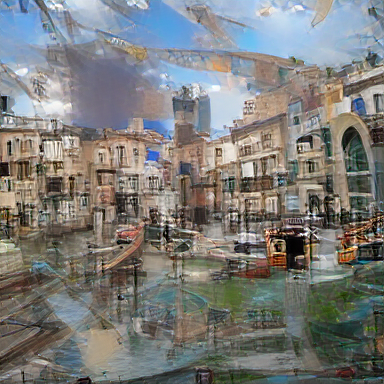

In [29]:
import torchvision.transforms as pth_transforms

decoder = decoder.to(device).eval()
inversed_transform = pth_transforms.Compose([
    pth_transforms.ToPILImage(),
])

gen = decoder(generated_tokens)
gen = ((gen + 1) / 2).clamp(0, 1)
gen = inversed_transform(gen.squeeze(0))

gen

after bottleneck x.shape: torch.Size([1, 576, 32])


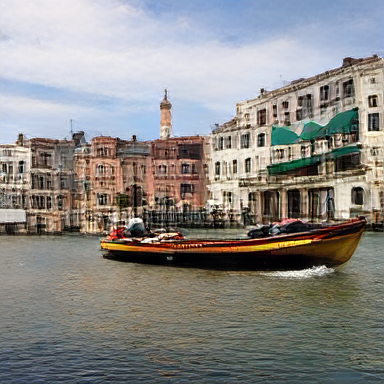

In [30]:
decoder = decoder.to(device).eval()
rec = decoder(img_features)
rec = ((rec + 1) / 2).clamp(0, 1)
rec = inversed_transform(rec.squeeze(0))

rec

In [5]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "/data1/ckpts/deepseek-ai_/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

# conversation = [
#     {
#         "role": "<|User|>",
#         "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
#     },
#     {"role": "<|Assistant|>", "content": ""},
# ]

# sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
#     conversations=conversation,
#     sft_format=vl_chat_processor.sft_format,
#     system_prompt="",
# )
# prompt = sft_format + vl_chat_processor.image_start_tag

prompt = "The image depicts a train on a railway track, likely part of the State Railway of Thailand (SRT), as indicated by the logo and text on the front of the train. The train is painted in a vibrant orange and blue color scheme with white accents. It appears to be a passenger train, given its design and the presence of multiple windows along its side. The train is traveling under an elevated concrete structure, possibly a bridge or overpass, which is supported by metal pillars. In the background, there are power lines and some greenery, suggesting the train is passing through a semi-urban or rural area. The overall scene conveys a sense of motion and travel, typical of a railway journey."

prompt = prompt + vl_chat_processor.image_start_tag
# input_ids = vl_chat_processor.tokenizer.encode(prompt)
# input_ids = torch.LongTensor(input_ids)
# input_ids = torch.cat([input_ids, 100002*torch.ones(150 - input_ids.shape[0], dtype=torch.long)], dim=0)
# input_ids = torch.cat([input_ids, torch.tensor([100003])]).to(device)


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 2,
    cfg_weight: float = 1,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state
        
        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]
        
        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
)

# play with HF datasets

In [6]:
from datasets import load_dataset

file_pattern = "sa_{:06d}.tar"
files_to_process = ["BLIP3o-Pretrain-Long-Caption/" + file_pattern.format(i) for i in range(0, 10)]

ds_BLIP3o = load_dataset("/data1/LargeData/BLIP3o", split="train", data_files=files_to_process, num_proc=64)

Setting num_proc from 64 to 10 for the train split as it only contains 10 shards.
Generating train split: 111837 examples [00:03, 28307.90 examples/s]


In [2]:
from util.dataloader import get_dataloader
from omegaconf import OmegaConf

config = OmegaConf.load("config/janus_gen.yaml")
dataloader = get_dataloader(config.data)